--- Running Bootstrap Pass (Non-Adaptive) to Find Initial Guess ---
--- Iteration 1 (k_guess=6.6902e-10, alpha_guess=3.087) ---
--- Iteration 2 (k_guess=1.1797e-10, alpha_guess=3.324) ---
Convergence reached. Final alpha = 3.324

--- Final Analysis Results ---
True Scaling Index (alpha): 4.4
Estimated Scaling Index (alpha): 3.324 +/- 0.076


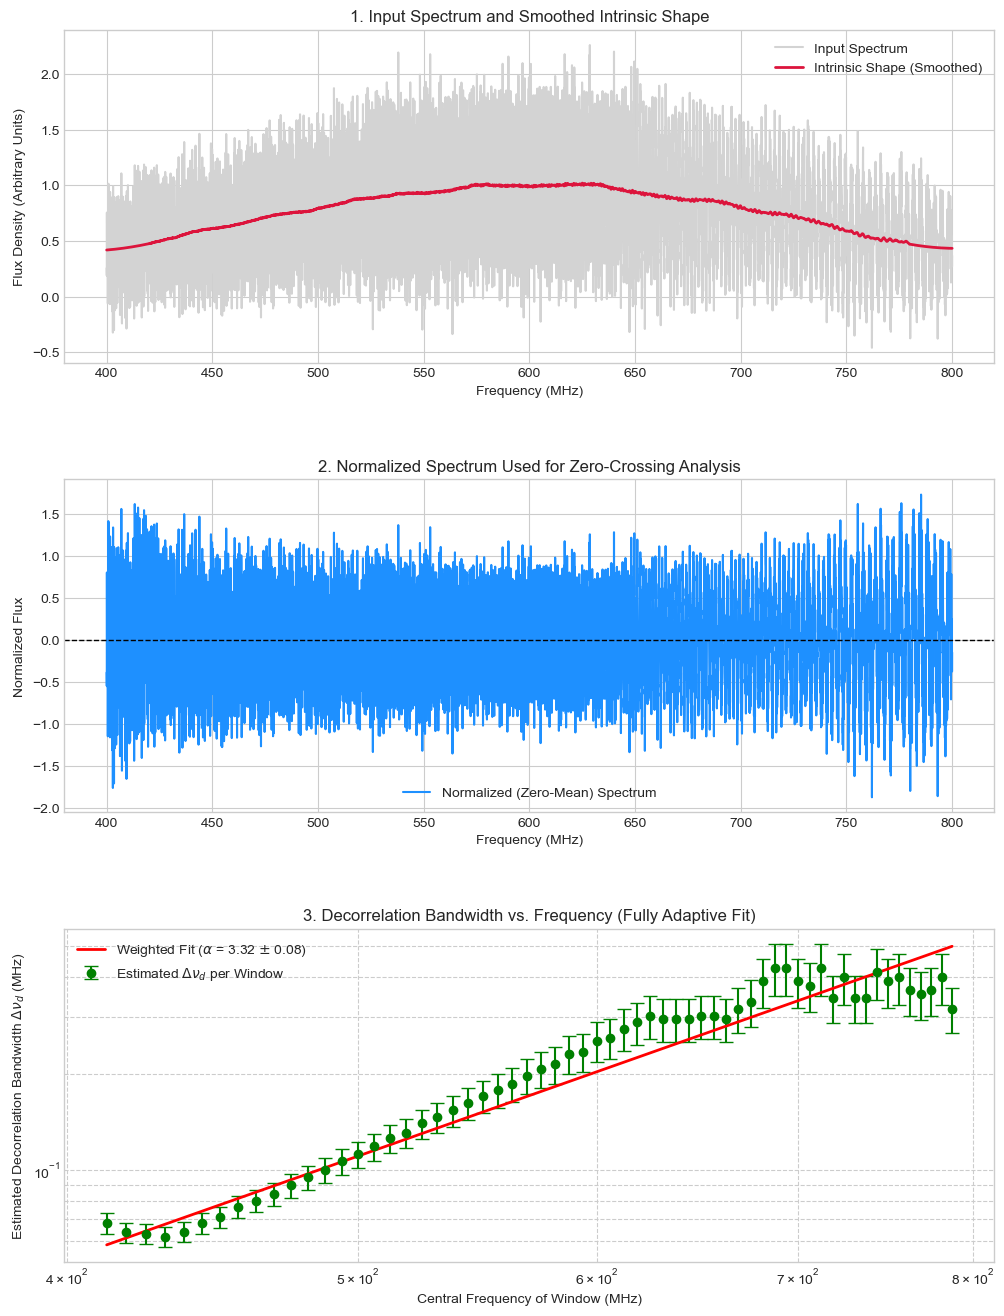

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# --- Core Analysis Functions ---

def _bootstrap_pass_analysis(freq_window, flux_window, fixed_smoothing_chans=5):
    """
    A simplified, non-adaptive analysis used only to get initial fit parameters.
    This is biased but robust against bad initial guesses.
    """
    if len(flux_window) < fixed_smoothing_chans:
        return np.nan, np.nan

    smoothed_flux = np.convolve(flux_window, np.ones(fixed_smoothing_chans)/fixed_smoothing_chans, mode='valid')
    zero_crossings = np.where(np.diff(np.sign(smoothed_flux)))[0]
    num_crossings = len(zero_crossings)

    if num_crossings < 2:
        return np.nan, np.nan

    full_window_width_mhz = freq_window[-1] - freq_window[0]
    effective_width_mhz = full_window_width_mhz * (len(smoothed_flux) / len(flux_window))
    zero_crossing_rate = num_crossings / effective_width_mhz
    
    delta_nu_d_mhz = (1.0 / (2.0 * zero_crossing_rate)) if zero_crossing_rate > 0 else np.nan
    err_delta_nu_d_mhz = delta_nu_d_mhz / np.sqrt(num_crossings)
    
    return delta_nu_d_mhz, err_delta_nu_d_mhz


def zero_crossing_analysis_adaptive(freq_window, flux_window, power_law_guess_func):
    """
    Performs zero-crossing analysis using an adaptive pre-smoothing filter.

    The width of the smoothing filter is adjusted based on a full power-law model
    (k * nu^alpha) from the previous iteration, removing systematic bias.

    Args:
        freq_window (np.ndarray): Frequencies for the window.
        flux_window (np.ndarray): Pre-normalized, zero-mean flux values.
        power_law_guess_func (callable): A function representing the power-law fit
                                         from the previous iteration. It should
                                         take frequency in MHz and return delta_nu_d.

    Returns:
        tuple: (Estimated bandwidth, uncertainty of bandwidth).
    """
    win_center_freq = np.mean(freq_window)
    channel_width_mhz = freq_window[1] - freq_window[0]

    expected_delta_nu = power_law_guess_func(win_center_freq)
    if np.isnan(expected_delta_nu) or expected_delta_nu <= 0:
        return np.nan, np.nan
        
    expected_delta_nu_chans = expected_delta_nu / channel_width_mhz
    adaptive_smoothing_chans = int(round(expected_delta_nu_chans / 4.0))

    adaptive_smoothing_chans = max(3, adaptive_smoothing_chans)
    if adaptive_smoothing_chans > len(flux_window):
        adaptive_smoothing_chans = len(flux_window)
    if adaptive_smoothing_chans % 2 == 0:
        adaptive_smoothing_chans -= 1
    
    if len(flux_window) < adaptive_smoothing_chans:
        return np.nan, np.nan

    smoothed_flux = np.convolve(flux_window, np.ones(adaptive_smoothing_chans)/adaptive_smoothing_chans, mode='valid')
    num_crossings = len(np.where(np.diff(np.sign(smoothed_flux)))[0])

    if num_crossings < 2:
        return np.nan, np.nan

    full_window_width_mhz = freq_window[-1] - freq_window[0]
    effective_width_mhz = full_window_width_mhz * (len(smoothed_flux) / len(flux_window))
    zero_crossing_rate = num_crossings / effective_width_mhz
    
    delta_nu_d_mhz = (1.0 / (2.0 * zero_crossing_rate)) if zero_crossing_rate > 0 else np.nan
    err_delta_nu_d_mhz = delta_nu_d_mhz / np.sqrt(num_crossings)
    
    return delta_nu_d_mhz, err_delta_nu_d_mhz

def power_law(nu, k, alpha):
    """Power law function for fitting: y = k * x^alpha"""
    return k * nu**alpha

def analyze_scintillation(freqs_mhz, spectrum_flux, convergence_tol=0.01, max_iterations=5):
    """
    Analyzes a spectrum for scintillation, iteratively fitting for the scaling index alpha.

    This function takes a raw FRB spectrum, normalizes it, and then iteratively
    applies an adaptive zero-crossing analysis to determine the frequency scaling
    of the decorrelation bandwidth.

    Args:
        freqs_mhz (np.ndarray): 1D array of frequency channels in MHz.
        spectrum_flux (np.ndarray): 1D array of flux density values. No prior
                                    normalization is required.
        convergence_tol (float): The tolerance for convergence. The iteration stops
                                 when the change in alpha is less than this value.
        max_iterations (int): The maximum number of iterations to prevent infinite loops.

    Returns:
        dict: A dictionary containing the final analysis results.
    """
    n_channels = len(freqs_mhz)
    
    # 1. Pre-process the full spectrum to remove the intrinsic shape
    smoothing_win_long = int(n_channels / 10) 
    if smoothing_win_long % 2 == 0: smoothing_win_long +=1 
    
    spectrum_smooth = savgol_filter(spectrum_flux, smoothing_win_long, 2)
    spectrum_normalized = spectrum_flux / spectrum_smooth
    spectrum_zero_mean = spectrum_normalized - 1
    
    # --- STAGE 1: Bootstrap Initial Guess ---
    print("--- Running Bootstrap Pass (Non-Adaptive) to Find Initial Guess ---")
    central_frequencies_boot = []
    estimated_bandwidths_boot = []
    window_size_chans = max(512, int(n_channels / 16))
    step_size_chans = max(128, int(window_size_chans / 4))
    
    for i in range(0, n_channels - window_size_chans + 1, step_size_chans):
        window_slice = slice(i, i + window_size_chans)
        delta_nu_d_est, _ = _bootstrap_pass_analysis(freqs_mhz[window_slice], spectrum_zero_mean[window_slice])
        if not np.isnan(delta_nu_d_est):
            central_frequencies_boot.append(np.mean(freqs_mhz[window_slice]))
            estimated_bandwidths_boot.append(delta_nu_d_est)

    if len(central_frequencies_boot) < 2:
        print("Bootstrap failed: Could not find enough valid data points.")
        return None
    
    # Fit the biased bootstrap data to get a reasonable starting point
    try:
        popt_boot, _ = curve_fit(power_law, central_frequencies_boot, estimated_bandwidths_boot, p0=[1e-9, 3.0])
    except RuntimeError:
        print("Bootstrap fit failed. Using default guess.")
        popt_boot = [1e-12, 4.0] # Fallback guess
    
    k_guess, alpha_guess = popt_boot
    
    # --- STAGE 2: Iteratively find the best-fit alpha ---
    for iteration in range(max_iterations):
        print(f"--- Iteration {iteration + 1} (k_guess={k_guess:.4e}, alpha_guess={alpha_guess:.3f}) ---")
        
        power_law_guess_func = lambda nu: power_law(nu, k_guess, alpha_guess)
        
        central_frequencies = []
        estimated_bandwidths = []
        bandwidth_uncertainties = []

        for i in range(0, n_channels - window_size_chans + 1, step_size_chans):
            window_slice = slice(i, i + window_size_chans)
            delta_nu_d_est, delta_nu_d_err = zero_crossing_analysis_adaptive(
                freqs_mhz[window_slice], spectrum_zero_mean[window_slice], power_law_guess_func
            )
            
            if not np.isnan(delta_nu_d_est):
                central_frequencies.append(np.mean(freqs_mhz[window_slice]))
                estimated_bandwidths.append(delta_nu_d_est)
                bandwidth_uncertainties.append(delta_nu_d_err)

        if len(central_frequencies) < 2:
            print("Adaptive analysis failed: Could not find enough valid data points.")
            return None

        try:
            popt, pcov = curve_fit(
                power_law, central_frequencies, estimated_bandwidths,
                sigma=bandwidth_uncertainties, absolute_sigma=True, p0=[k_guess, alpha_guess]
            )
        except RuntimeError:
            print("Fit failed to converge in this iteration. Aborting.")
            return None

        estimated_k, estimated_alpha = popt
        
        if abs(estimated_alpha - alpha_guess) < convergence_tol:
            print(f"Convergence reached. Final alpha = {estimated_alpha:.3f}")
            break
        
        k_guess, alpha_guess = estimated_k, estimated_alpha
    else:
         print("Warning: Maximum iterations reached without convergence.")
            
    err_k, err_alpha = np.sqrt(np.diag(pcov))

    return {
        "freqs": freqs_mhz, "spectrum_flux": spectrum_flux, "spectrum_smooth": spectrum_smooth,
        "spectrum_zero_mean": spectrum_zero_mean, "central_frequencies": np.array(central_frequencies),
        "estimated_bandwidths": np.array(estimated_bandwidths), "bandwidth_uncertainties": np.array(bandwidth_uncertainties),
        "estimated_alpha": estimated_alpha, "err_alpha": err_alpha, "estimated_k": estimated_k, "err_k": err_k
    }

def plot_analysis_results(results):
    """Visualizes the results from the analyze_scintillation function."""
    if results is None: return
    fit_function = lambda nu: power_law(nu, results['estimated_k'], results['estimated_alpha'])
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(12, 16))
    gs = fig.add_gridspec(3, 1, hspace=0.35)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(results['freqs'], results['spectrum_flux'], label='Input Spectrum', color='lightgray', zorder=1)
    ax1.plot(results['freqs'], results['spectrum_smooth'], label='Intrinsic Shape (Smoothed)', color='crimson', lw=2, zorder=2)
    ax1.set_title("1. Input Spectrum and Smoothed Intrinsic Shape")
    ax1.set_xlabel("Frequency (MHz)"), ax1.set_ylabel("Flux Density (Arbitrary Units)"), ax1.legend()

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(results['freqs'], results['spectrum_zero_mean'], label='Normalized (Zero-Mean) Spectrum', color='dodgerblue')
    ax2.axhline(0, color='black', linestyle='--', lw=1)
    ax2.set_title("2. Normalized Spectrum Used for Zero-Crossing Analysis")
    ax2.set_xlabel("Frequency (MHz)"), ax2.set_ylabel("Normalized Flux"), ax2.legend()
    
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.errorbar(
        results['central_frequencies'], results['estimated_bandwidths'], yerr=results['bandwidth_uncertainties'],
        fmt='o', label='Estimated $\Delta\\nu_d$ per Window', color='green', capsize=5
    )
    fit_label = f'Weighted Fit ($\\alpha$ = {results["estimated_alpha"]:.2f} $\pm$ {results["err_alpha"]:.2f})'
    ax3.loglog(results['central_frequencies'], fit_function(results['central_frequencies']), 'r-', label=fit_label, lw=2)
    ax3.set_title("3. Decorrelation Bandwidth vs. Frequency (Fully Adaptive Fit)")
    ax3.set_xlabel("Central Frequency of Window (MHz)"), ax3.set_ylabel("Estimated Decorrelation Bandwidth $\Delta\\nu_d$ (MHz)")
    ax3.set_yscale('log'), ax3.set_xscale('log'), ax3.legend(), ax3.grid(True, which="both", ls="--")
    
    plt.show()

# --- Helper Function for Demonstration ---

def generate_synthetic_spectrum(freqs_mhz, center_freq, bandwidth, alpha, noise_level, scint_strength, target_delta_nu_center):
    """Generates a realistic synthetic FRB spectrum for demonstration purposes."""
    intrinsic_spectrum = np.exp(-0.5 * ((freqs_mhz - center_freq) / (bandwidth / 2.355))**2)
    
    # Correctly calculate k based on the physical definition
    k = target_delta_nu_center / (center_freq**alpha)
    
    # Correctly calculate phase as the integral of 2*pi / (k * nu^alpha)
    # This ensures the local oscillation frequency matches the desired decorrelation bandwidth
    if abs(1 - alpha) < 1e-9:
        phase = (2 * np.pi / k) * np.log(freqs_mhz)
    else:
        phase = (2 * np.pi / (k * (1 - alpha))) * freqs_mhz**(1-alpha)
        
    scintillation_pattern = 1 + scint_strength * np.sin(phase)
    scintillated_spectrum = intrinsic_spectrum * scintillation_pattern
    noise = np.random.normal(0, noise_level * np.max(intrinsic_spectrum), len(freqs_mhz))
    return scintillated_spectrum + noise

# --- Main Analysis Script ---
if __name__ == '__main__':
    TRUE_ALPHA = 4.4
    N_CHANNELS = 8192
    FREQ_START_MHZ = 400
    FREQ_END_MHZ = 800
    
    freqs = np.linspace(FREQ_START_MHZ, FREQ_END_MHZ, N_CHANNELS)
    flux = generate_synthetic_spectrum(
        freqs, center_freq=600, bandwidth=350, alpha=TRUE_ALPHA, 
        noise_level=0.20, scint_strength=0.7, target_delta_nu_center=1.0 
    )

    analysis_results = analyze_scintillation(freqs, flux)
    
    if analysis_results:
        print("\n--- Final Analysis Results ---")
        print(f"True Scaling Index (alpha): {TRUE_ALPHA}")
        est_alpha = analysis_results['estimated_alpha']
        err_alpha = analysis_results['err_alpha']
        print(f"Estimated Scaling Index (alpha): {est_alpha:.3f} +/- {err_alpha:.3f}")
        plot_analysis_results(analysis_results)


--- Running Bootstrap Pass (Non-Adaptive) to Find Initial Guess ---
--- Iteration 1 (k_guess=9.7177e-10, alpha_guess=3.033) ---
--- Iteration 2 (k_guess=2.9408e-10, alpha_guess=3.178) ---
Convergence reached. Final alpha = 3.178

--- Final Analysis Results ---
True Scaling Index (alpha): 4.4
Estimated Scaling Index (alpha): 3.178 +/- 0.076


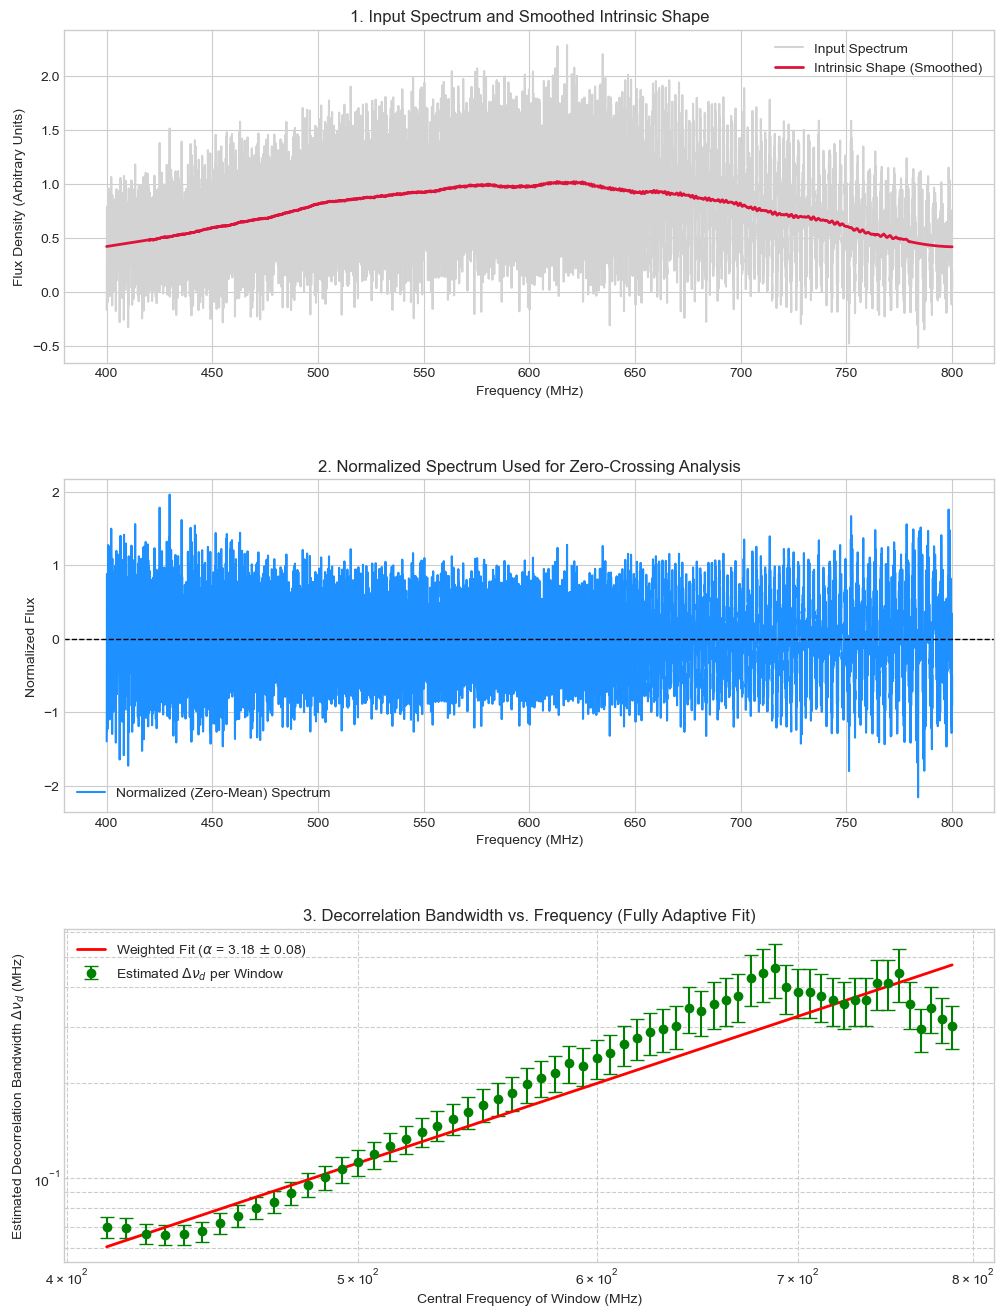

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# --- Core Analysis Functions ---

def _bootstrap_pass_analysis(freq_window, flux_window, fixed_smoothing_chans=5):
    """
    A simplified, non-adaptive analysis used only to get initial fit parameters.
    This is biased but robust against bad initial guesses.
    """
    if len(flux_window) < fixed_smoothing_chans:
        return np.nan, np.nan

    smoothed_flux = np.convolve(flux_window, np.ones(fixed_smoothing_chans)/fixed_smoothing_chans, mode='valid')
    zero_crossings = np.where(np.diff(np.sign(smoothed_flux)))[0]
    num_crossings = len(zero_crossings)

    if num_crossings < 2:
        return np.nan, np.nan

    full_window_width_mhz = freq_window[-1] - freq_window[0]
    effective_width_mhz = full_window_width_mhz * (len(smoothed_flux) / len(flux_window))
    zero_crossing_rate = num_crossings / effective_width_mhz
    
    delta_nu_d_mhz = (1.0 / (2.0 * zero_crossing_rate)) if zero_crossing_rate > 0 else np.nan
    err_delta_nu_d_mhz = delta_nu_d_mhz / np.sqrt(num_crossings)
    
    return delta_nu_d_mhz, err_delta_nu_d_mhz


def zero_crossing_analysis_adaptive(freq_window, flux_window, power_law_guess_func):
    """
    Performs zero-crossing analysis using an adaptive pre-smoothing filter.

    The width of the smoothing filter is adjusted based on a full power-law model
    (k * nu^alpha) from the previous iteration, removing systematic bias.

    Args:
        freq_window (np.ndarray): Frequencies for the window.
        flux_window (np.ndarray): Pre-normalized, zero-mean flux values.
        power_law_guess_func (callable): A function representing the power-law fit
                                         from the previous iteration. It should
                                         take frequency in MHz and return delta_nu_d.

    Returns:
        tuple: (Estimated bandwidth, uncertainty of bandwidth).
    """
    win_center_freq = np.mean(freq_window)
    channel_width_mhz = freq_window[1] - freq_window[0]

    expected_delta_nu = power_law_guess_func(win_center_freq)
    if np.isnan(expected_delta_nu) or expected_delta_nu <= 0:
        return np.nan, np.nan
        
    expected_delta_nu_chans = expected_delta_nu / channel_width_mhz
    adaptive_smoothing_chans = int(round(expected_delta_nu_chans / 4.0))

    adaptive_smoothing_chans = max(3, adaptive_smoothing_chans)
    if adaptive_smoothing_chans > len(flux_window):
        adaptive_smoothing_chans = len(flux_window)
    if adaptive_smoothing_chans % 2 == 0:
        adaptive_smoothing_chans -= 1
    
    if len(flux_window) < adaptive_smoothing_chans:
        return np.nan, np.nan

    smoothed_flux = np.convolve(flux_window, np.ones(adaptive_smoothing_chans)/adaptive_smoothing_chans, mode='valid')
    num_crossings = len(np.where(np.diff(np.sign(smoothed_flux)))[0])

    if num_crossings < 2:
        return np.nan, np.nan

    full_window_width_mhz = freq_window[-1] - freq_window[0]
    effective_width_mhz = full_window_width_mhz * (len(smoothed_flux) / len(flux_window))
    zero_crossing_rate = num_crossings / effective_width_mhz
    
    delta_nu_d_mhz = (1.0 / (2.0 * zero_crossing_rate)) if zero_crossing_rate > 0 else np.nan
    err_delta_nu_d_mhz = delta_nu_d_mhz / np.sqrt(num_crossings)
    
    return delta_nu_d_mhz, err_delta_nu_d_mhz

def power_law(nu, k, alpha):
    """Power law function for fitting: y = k * x^alpha"""
    return k * nu**alpha

def analyze_scintillation(freqs_mhz, spectrum_flux, convergence_tol=0.01, max_iterations=5):
    """
    Analyzes a spectrum for scintillation, iteratively fitting for the scaling index alpha.

    This function takes a raw FRB spectrum, normalizes it, and then iteratively
    applies an adaptive zero-crossing analysis to determine the frequency scaling
    of the decorrelation bandwidth.

    Args:
        freqs_mhz (np.ndarray): 1D array of frequency channels in MHz.
        spectrum_flux (np.ndarray): 1D array of flux density values. No prior
                                    normalization is required.
        convergence_tol (float): The tolerance for convergence. The iteration stops
                                 when the change in alpha is less than this value.
        max_iterations (int): The maximum number of iterations to prevent infinite loops.

    Returns:
        dict: A dictionary containing the final analysis results.
    """
    n_channels = len(freqs_mhz)
    
    # 1. Pre-process the full spectrum to remove the intrinsic shape
    smoothing_win_long = int(n_channels / 10) 
    if smoothing_win_long % 2 == 0: smoothing_win_long +=1 
    
    spectrum_smooth = savgol_filter(spectrum_flux, smoothing_win_long, 2)
    spectrum_normalized = spectrum_flux / spectrum_smooth
    spectrum_zero_mean = spectrum_normalized - 1
    
    # --- STAGE 1: Bootstrap Initial Guess ---
    print("--- Running Bootstrap Pass (Non-Adaptive) to Find Initial Guess ---")
    central_frequencies_boot = []
    estimated_bandwidths_boot = []
    window_size_chans = max(512, int(n_channels / 16))
    step_size_chans = max(128, int(window_size_chans / 4))
    
    for i in range(0, n_channels - window_size_chans + 1, step_size_chans):
        window_slice = slice(i, i + window_size_chans)
        delta_nu_d_est, _ = _bootstrap_pass_analysis(freqs_mhz[window_slice], spectrum_zero_mean[window_slice])
        if not np.isnan(delta_nu_d_est):
            central_frequencies_boot.append(np.mean(freqs_mhz[window_slice]))
            estimated_bandwidths_boot.append(delta_nu_d_est)

    if len(central_frequencies_boot) < 2:
        print("Bootstrap failed: Could not find enough valid data points.")
        return None
    
    # Fit the biased bootstrap data to get a reasonable starting point
    try:
        popt_boot, _ = curve_fit(power_law, central_frequencies_boot, estimated_bandwidths_boot, p0=[1e-9, 3.0])
    except RuntimeError:
        print("Bootstrap fit failed. Using default guess.")
        popt_boot = [1e-12, 4.0] # Fallback guess
    
    k_guess, alpha_guess = popt_boot
    
    # --- STAGE 2: Iteratively find the best-fit alpha ---
    for iteration in range(max_iterations):
        print(f"--- Iteration {iteration + 1} (k_guess={k_guess:.4e}, alpha_guess={alpha_guess:.3f}) ---")
        
        power_law_guess_func = lambda nu: power_law(nu, k_guess, alpha_guess)
        
        central_frequencies = []
        estimated_bandwidths = []
        bandwidth_uncertainties = []

        for i in range(0, n_channels - window_size_chans + 1, step_size_chans):
            window_slice = slice(i, i + window_size_chans)
            delta_nu_d_est, delta_nu_d_err = zero_crossing_analysis_adaptive(
                freqs_mhz[window_slice], spectrum_zero_mean[window_slice], power_law_guess_func
            )
            
            if not np.isnan(delta_nu_d_est):
                central_frequencies.append(np.mean(freqs_mhz[window_slice]))
                estimated_bandwidths.append(delta_nu_d_est)
                bandwidth_uncertainties.append(delta_nu_d_err)

        if len(central_frequencies) < 2:
            print("Adaptive analysis failed: Could not find enough valid data points.")
            return None

        try:
            popt, pcov = curve_fit(
                power_law, central_frequencies, estimated_bandwidths,
                sigma=bandwidth_uncertainties, absolute_sigma=True, p0=[k_guess, alpha_guess]
            )
        except RuntimeError:
            print("Fit failed to converge in this iteration. Aborting.")
            return None

        estimated_k, estimated_alpha = popt
        
        if abs(estimated_alpha - alpha_guess) < convergence_tol:
            print(f"Convergence reached. Final alpha = {estimated_alpha:.3f}")
            break
        
        k_guess, alpha_guess = estimated_k, estimated_alpha
    else:
         print("Warning: Maximum iterations reached without convergence.")
            
    err_k, err_alpha = np.sqrt(np.diag(pcov))

    return {
        "freqs": freqs_mhz, "spectrum_flux": spectrum_flux, "spectrum_smooth": spectrum_smooth,
        "spectrum_zero_mean": spectrum_zero_mean, "central_frequencies": np.array(central_frequencies),
        "estimated_bandwidths": np.array(estimated_bandwidths), "bandwidth_uncertainties": np.array(bandwidth_uncertainties),
        "estimated_alpha": estimated_alpha, "err_alpha": err_alpha, "estimated_k": estimated_k, "err_k": err_k
    }

def plot_analysis_results(results):
    """Visualizes the results from the analyze_scintillation function."""
    if results is None: return
    fit_function = lambda nu: power_law(nu, results['estimated_k'], results['estimated_alpha'])
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(12, 16))
    gs = fig.add_gridspec(3, 1, hspace=0.35)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(results['freqs'], results['spectrum_flux'], label='Input Spectrum', color='lightgray', zorder=1)
    ax1.plot(results['freqs'], results['spectrum_smooth'], label='Intrinsic Shape (Smoothed)', color='crimson', lw=2, zorder=2)
    ax1.set_title("1. Input Spectrum and Smoothed Intrinsic Shape")
    ax1.set_xlabel("Frequency (MHz)"), ax1.set_ylabel("Flux Density (Arbitrary Units)"), ax1.legend()

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(results['freqs'], results['spectrum_zero_mean'], label='Normalized (Zero-Mean) Spectrum', color='dodgerblue')
    ax2.axhline(0, color='black', linestyle='--', lw=1)
    ax2.set_title("2. Normalized Spectrum Used for Zero-Crossing Analysis")
    ax2.set_xlabel("Frequency (MHz)"), ax2.set_ylabel("Normalized Flux"), ax2.legend()
    
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.errorbar(
        results['central_frequencies'], results['estimated_bandwidths'], yerr=results['bandwidth_uncertainties'],
        fmt='o', label='Estimated $\Delta\\nu_d$ per Window', color='green', capsize=5
    )
    fit_label = f'Weighted Fit ($\\alpha$ = {results["estimated_alpha"]:.2f} $\pm$ {results["err_alpha"]:.2f})'
    ax3.loglog(results['central_frequencies'], fit_function(results['central_frequencies']), 'r-', label=fit_label, lw=2)
    ax3.set_title("3. Decorrelation Bandwidth vs. Frequency (Fully Adaptive Fit)")
    ax3.set_xlabel("Central Frequency of Window (MHz)"), ax3.set_ylabel("Estimated Decorrelation Bandwidth $\Delta\\nu_d$ (MHz)")
    ax3.set_yscale('log'), ax3.set_xscale('log'), ax3.legend(), ax3.grid(True, which="both", ls="--")
    
    plt.show()

# --- Helper Function for Demonstration ---

def generate_synthetic_spectrum(freqs_mhz, center_freq, bandwidth, alpha, noise_level, scint_strength, target_delta_nu_center):
    """Generates a realistic synthetic FRB spectrum for demonstration purposes."""
    intrinsic_spectrum = np.exp(-0.5 * ((freqs_mhz - center_freq) / (bandwidth / 2.355))**2)
    
    # Correctly calculate k based on the physical definition
    k = target_delta_nu_center / (center_freq**alpha)
    
    # Correctly calculate phase as the integral of 2*pi / (k * nu^alpha)
    # This ensures the local oscillation frequency matches the desired decorrelation bandwidth
    if abs(1 - alpha) < 1e-9:
        phase = (2 * np.pi / k) * np.log(freqs_mhz)
    else:
        phase = (2 * np.pi / (k * (1 - alpha))) * freqs_mhz**(1-alpha)
        
    scintillation_pattern = 1 + scint_strength * np.sin(phase)
    scintillated_spectrum = intrinsic_spectrum * scintillation_pattern
    noise = np.random.normal(0, noise_level * np.max(intrinsic_spectrum), len(freqs_mhz))
    return scintillated_spectrum + noise

# --- Main Analysis Script ---
if __name__ == '__main__':
    TRUE_ALPHA = 4.4
    N_CHANNELS = 8192
    FREQ_START_MHZ = 400
    FREQ_END_MHZ = 800
    
    freqs = np.linspace(FREQ_START_MHZ, FREQ_END_MHZ, N_CHANNELS)
    flux = generate_synthetic_spectrum(
        freqs, center_freq=600, bandwidth=350, alpha=TRUE_ALPHA, 
        noise_level=0.20, scint_strength=0.7, target_delta_nu_center=1.0 
    )

    analysis_results = analyze_scintillation(freqs, flux)
    
    if analysis_results:
        print("\n--- Final Analysis Results ---")
        print(f"True Scaling Index (alpha): {TRUE_ALPHA}")
        est_alpha = analysis_results['estimated_alpha']
        err_alpha = analysis_results['err_alpha']
        print(f"Estimated Scaling Index (alpha): {est_alpha:.3f} +/- {err_alpha:.3f}")
        plot_analysis_results(analysis_results)
